In [13]:
from utils import *
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
st = "2020-07-19 00:00:00"
et = "2020-08-02 23:59:59"

In [6]:
power_df = get_data_section(client, '_power', st, et, uuid_dict, '1T')
power_df = power_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean()

power_df.head()

,building,freezer,ref_comp,ref_fan,hvac_west,hvac_east
2020-07-19 00:00:00,34176.875000,4044.173828,14.919643,442.498840,2939.602051,3241.283203
2020-07-19 00:01:00,33548.640625,4026.793457,9.962272,42.042839,2922.791992,3238.636719
2020-07-19 00:02:00,39468.203125,3994.485596,4270.938965,447.384949,NaN,NaN
2020-07-19 00:03:00,NaN,NaN,NaN,NaN,2926.823730,3233.962891
2020-07-19 00:04:00,34266.390625,3978.000977,13.444770,443.142883,2931.019287,3234.100342


In [7]:
weather_df = get_data_section(client, '_current', st, et, uuid_dict, '1T')
weather_df = weather_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear')#.resample('15T').mean()
weather_df.head()

,oat,humidity,windspeed,cloudcover,solar,sr
2020-07-19 00:02:00,60.720000,76.0,1.900000,0.02,0.0,0.0
2020-07-19 00:03:00,60.714667,76.0,1.903333,0.02,0.0,0.0
2020-07-19 00:04:00,60.709333,76.0,1.906667,0.02,0.0,0.0
2020-07-19 00:05:00,60.704000,76.0,1.910000,0.02,0.0,0.0
2020-07-19 00:06:00,60.698667,76.0,1.913333,0.02,0.0,0.0


In [9]:
battery_df = get_data_section(client, '_battery', st, et, uuid_dict, '1T')
battery_df = battery_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean()#.resample('15T').mean()

# changing pv to new value 
battery_df.pv_generation = weather_df.sr * 272.6 * 0.26 * 0.98

battery_df.head()

,soc,setpoint,pv_generation
2020-07-19 00:00:00,0.674426,0.0,NaN
2020-07-19 00:01:00,0.674426,0.0,NaN
2020-07-19 00:02:00,0.674426,0.0,0.0
2020-07-19 00:03:00,0.674426,0.0,0.0
2020-07-19 00:04:00,0.674426,0.0,0.0


In [10]:
X = power_df[['building']]
X.columns = ['net_load']
# X['pv'] = battery_df.pv_generation
X['oat'] = weather_df['oat']
# X.net_load = X.net_load - X.pv
# X = X.drop(columns=['pv']).dropna().resample('30T').mean()
X = X.dropna().resample('30T').mean()
X['tod'] = X.index.hour * 60 + X.index.minute
X['dow'] = X.index.weekday

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
X.head()

,net_load,oat,tod,dow
2020-07-19 00:00:00,36396.911855,60.652986,0,6
2020-07-19 00:30:00,34585.441406,60.468747,30,6
2020-07-19 01:00:00,32977.975210,60.227718,60,6
2020-07-19 01:30:00,33934.786784,59.592148,90,6
2020-07-19 02:00:00,35473.382546,58.795840,120,6


In [14]:
reg = LinearRegression().fit(X[['oat', 'tod', 'dow']], X['net_load'])

## change the test date below¶

In [15]:
test_date = "2020-09-22"

In [16]:
q_latest_ts = "select last(value), time from timeseries where time > now() - 13m and \"uuid\"='%s'"%(uuid_dict['oat_forecast'])
latest_ts_res = client.query(q_latest_ts)

In [17]:
latest_ts = latest_ts_res['timeseries'].index.values[0].astype('uint64')

In [18]:
q_solar_forecast = "select prediction_time, value from %s where \"uuid\"=\'%s\'" % ('timeseries', uuid_dict['solar_forecast'])
q_solar_forecast += " and time= " + (str(latest_ts))
test_weather_df1 = client.query(q_solar_forecast)['timeseries']
test_weather_df1 = test_weather_df1[['prediction_time', 'value']]
test_weather_df1.prediction_time = pd.to_datetime(test_weather_df1.prediction_time.astype(int) * 1e9)
test_weather_df1 = test_weather_df1.sort_values(by='prediction_time').set_index('prediction_time').tz_localize(tz_utc)
test_weather_df1.index.name = 'time'
test_weather_df1.columns = ['pv']

q_oat_forecast = "select prediction_time, value from %s where \"uuid\"=\'%s\'" % ('timeseries', uuid_dict['oat_forecast'])
q_oat_forecast += " and time= " + (str(latest_ts))
test_weather_df2 = client.query(q_oat_forecast)['timeseries']
test_weather_df2 = test_weather_df2[['prediction_time', 'value']]
test_weather_df2.prediction_time = pd.to_datetime(test_weather_df2.prediction_time.astype(int) * 1e9)
test_weather_df2 = test_weather_df2.sort_values(by='prediction_time').set_index('prediction_time').tz_localize(tz_utc)
test_weather_df2.index.name = 'time'
test_weather_df2.columns = ['oat']

test_weather_forecast_df = pd.concat([test_weather_df1, test_weather_df2], axis=1)

In [19]:
test_weather_forecast_df.head()

,pv,oat
time,,
2020-09-21 21:00:00+00:00,446.489136,70.12
2020-09-21 22:00:00+00:00,390.444305,69.63
2020-09-21 23:00:00+00:00,208.184753,67.78
2020-09-22 00:00:00+00:00,122.835056,65.72
2020-09-22 01:00:00+00:00,33.707604,64.44


In [20]:
test_st = test_date+" 00:00:00"
test_et = test_date+" 23:59:59"

test_st = tz_local.localize(datetime.datetime.strptime(test_st, "%Y-%m-%d %H:%M:%S")).astimezone(tz_utc)
test_et = tz_local.localize(datetime.datetime.strptime(test_et, "%Y-%m-%d %H:%M:%S")).astimezone(tz_utc)

test_weather_df = test_weather_forecast_df.loc[test_st: test_et]
test_weather_df

,pv,oat
time,,
2020-09-22 07:00:00+00:00,0.000000,58.53
2020-09-22 08:00:00+00:00,0.000000,58.59
2020-09-22 09:00:00+00:00,0.000000,58.43
2020-09-22 10:00:00+00:00,0.000000,57.87
2020-09-22 11:00:00+00:00,0.000000,57.67
2020-09-22 12:00:00+00:00,0.000000,57.21
2020-09-22 13:00:00+00:00,0.000000,56.53
2020-09-22 14:00:00+00:00,0.000000,55.62
2020-09-22 15:00:00+00:00,3.942175,55.59


In [21]:
Y = test_weather_df[['oat']]
Y = Y.resample('30T').mean().interpolate(method='linear')
Y['tod'] = Y.index.hour * 60 + Y.index.minute
Y['dow'] = Y.index.weekday
Y['net_load'] = reg.predict(Y)

In [22]:
Y.head()

,oat,tod,dow,net_load
time,,,,
2020-09-22 07:00:00+00:00,58.53,420,1,35128.289409
2020-09-22 07:30:00+00:00,58.56,450,1,35193.882185
2020-09-22 08:00:00+00:00,58.59,480,1,35259.474960
2020-09-22 08:30:00+00:00,58.51,510,1,35316.278970
2020-09-22 09:00:00+00:00,58.43,540,1,35373.082980


/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


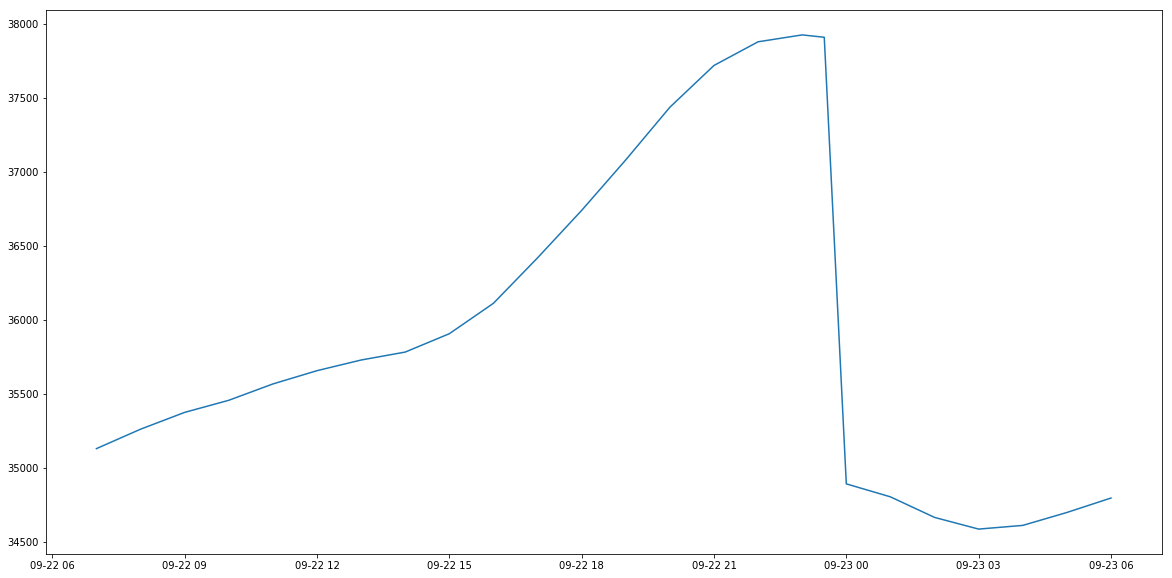

In [23]:
plt.figure(figsize=(20,10))
plt.plot(Y.tz_convert(tz_local).net_load)

In [24]:
Y.tz_convert(tz_local)[test_date].net_load

time
2020-09-22 00:00:00-07:00    35128.289409
2020-09-22 00:30:00-07:00    35193.882185
2020-09-22 01:00:00-07:00    35259.474960
2020-09-22 01:30:00-07:00    35316.278970
2020-09-22 02:00:00-07:00    35373.082980
2020-09-22 02:30:00-07:00    35413.907416
2020-09-22 03:00:00-07:00    35454.731852
2020-09-22 03:30:00-07:00    35509.937905
2020-09-22 04:00:00-07:00    35565.143957
2020-09-22 04:30:00-07:00    35609.963287
2020-09-22 05:00:00-07:00    35654.782616
2020-09-22 05:30:00-07:00    35690.813180
2020-09-22 06:00:00-07:00    35726.843744
2020-09-22 06:30:00-07:00    35753.686053
2020-09-22 07:00:00-07:00    35780.528361
2020-09-22 07:30:00-07:00    35842.525733
2020-09-22 08:00:00-07:00    35904.523104
2020-09-22 08:30:00-07:00    36007.268389
2020-09-22 09:00:00-07:00    36110.013674
2020-09-22 09:30:00-07:00    36263.494106
2020-09-22 10:00:00-07:00    36416.974538
2020-09-22 10:30:00-07:00    36577.246289
2020-09-22 11:00:00-07:00    36737.518040
2020-09-22 11:30:00-07:00    

In [25]:
test_weather_df.tz_convert(tz_local)[test_date].pv * 272.6 * 0.26 * 0.98

time
2020-09-22 00:00:00-07:00        0.000000
2020-09-22 01:00:00-07:00        0.000000
2020-09-22 02:00:00-07:00        0.000000
2020-09-22 03:00:00-07:00        0.000000
2020-09-22 04:00:00-07:00        0.000000
2020-09-22 05:00:00-07:00        0.000000
2020-09-22 06:00:00-07:00        0.000000
2020-09-22 07:00:00-07:00        0.000000
2020-09-22 08:00:00-07:00      273.817511
2020-09-22 09:00:00-07:00     4110.573803
2020-09-22 10:00:00-07:00    11777.440955
2020-09-22 11:00:00-07:00    20363.280965
2020-09-22 12:00:00-07:00    31001.551158
2020-09-22 13:00:00-07:00    32699.943703
2020-09-22 14:00:00-07:00    32400.065362
2020-09-22 15:00:00-07:00    30777.678790
2020-09-22 16:00:00-07:00    25229.084998
2020-09-22 17:00:00-07:00    16188.673232
2020-09-22 18:00:00-07:00     6682.590447
2020-09-22 19:00:00-07:00        0.000000
2020-09-22 20:00:00-07:00        0.000000
2020-09-22 21:00:00-07:00        0.000000
2020-09-22 22:00:00-07:00        0.000000
2020-09-22 23:00:00-07:00    

In [27]:
net_load = Y.tz_convert(tz_local)[test_date].net_load - test_weather_df.tz_convert(tz_local)[test_date].resample('30T').interpolate().pv * 272.6 * 0.26 * 0.98

In [28]:
net_load

time
2020-09-22 00:00:00-07:00    35128.289409
2020-09-22 00:30:00-07:00    35193.882185
2020-09-22 01:00:00-07:00    35259.474960
2020-09-22 01:30:00-07:00    35316.278970
2020-09-22 02:00:00-07:00    35373.082980
2020-09-22 02:30:00-07:00    35413.907416
2020-09-22 03:00:00-07:00    35454.731852
2020-09-22 03:30:00-07:00    35509.937905
2020-09-22 04:00:00-07:00    35565.143957
2020-09-22 04:30:00-07:00    35609.963287
2020-09-22 05:00:00-07:00    35654.782616
2020-09-22 05:30:00-07:00    35690.813180
2020-09-22 06:00:00-07:00    35726.843744
2020-09-22 06:30:00-07:00    35753.686053
2020-09-22 07:00:00-07:00    35780.528361
2020-09-22 07:30:00-07:00    35705.616977
2020-09-22 08:00:00-07:00    35630.705593
2020-09-22 08:30:00-07:00    33815.072732
2020-09-22 09:00:00-07:00    31999.439871
2020-09-22 09:30:00-07:00    28319.486727
2020-09-22 10:00:00-07:00    24639.533583
2020-09-22 10:30:00-07:00    20506.885329
2020-09-22 11:00:00-07:00    16374.237075
2020-09-22 11:30:00-07:00    

In [38]:
net_load["2020-09-22 12:00:00": "2020-09-22 15:00:00"]

time
2020-09-22 12:00:00-07:00    6077.283830
2020-09-22 12:30:00-07:00    5405.936840
2020-09-22 13:00:00-07:00    4734.589850
2020-09-22 13:30:00-07:00    5025.625283
2020-09-22 14:00:00-07:00    5316.660715
2020-09-22 14:30:00-07:00    6207.828393
2020-09-22 15:00:00-07:00    7098.996071
Freq: 30T, dtype: float64

In [34]:
[i-5000 for i in [11000, 11000, 10400, 10400, 9700, 9700, 10000, 10000, 10300, 10300, 11200, 11200]]

[6000, 6000, 5400, 5400, 4700, 4700, 5000, 5000, 5300, 5300, 6200, 6200]

In [39]:
net_load["2020-09-22 15:00:00": "2020-09-22 18:00:00"]

time
2020-09-22 15:00:00-07:00     7098.996071
2020-09-22 15:30:00-07:00     9896.539872
2020-09-22 16:00:00-07:00    12694.083673
2020-09-22 16:30:00-07:00    17198.386505
2020-09-22 17:00:00-07:00    18701.538756
2020-09-22 17:30:00-07:00    23410.712843
2020-09-22 18:00:00-07:00    28119.886929
Freq: 30T, dtype: float64

In [36]:
[i+5000 for i in [2100, 2100, 4900, 4900, 7700, 7700, 12200, 12200, 13700, 13700, 18400, 18400]]

[7100,
 7100,
 9900,
 9900,
 12700,
 12700,
 17200,
 17200,
 18700,
 18700,
 23400,
 23400]